In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

In [2]:
train_df = pd.read_csv("child-mind-institute-problematic-internet-use/train.csv")
test_df = pd.read_csv("child-mind-institute-problematic-internet-use/test.csv")

In [3]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

In [4]:
def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

In [5]:
train_df = train_df.dropna(subset=['sii'])

In [6]:
PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]
def IncorrectRows(row):
    if pd.isna(row['PCIAT-PCIAT_Total']):
        return np.nan
    max_possible = row['PCIAT-PCIAT_Total'] + row[PCIAT_cols].isna().sum() * 5
    if row['PCIAT-PCIAT_Total'] <= 30 and max_possible <= 30:
        return 0
    elif 31 <= row['PCIAT-PCIAT_Total'] <= 49 and max_possible <= 49:
        return 1
    elif 50 <= row['PCIAT-PCIAT_Total'] <= 79 and max_possible <= 79:
        return 2
    elif row['PCIAT-PCIAT_Total'] >= 80 and max_possible >= 80:
        return 3
    return np.nan

train_df['recal_sii'] = train_df.apply(IncorrectRows, axis=1)

In [7]:
mismatch_rows = train_df[
    (train_df['recal_sii'] != train_df['sii']) & train_df['sii'].notna()
]
mismatch_indexes = mismatch_rows.index
train_df = train_df.drop(mismatch_indexes)
train_df = train_df.drop(['recal_sii'], axis=1)

In [8]:
SEASON_COLS = [
    "Basic_Demos-Enroll_Season", 
    "CGAS-Season", 
    "Physical-Season", 
    "Fitness_Endurance-Season", 
    "FGC-Season", 
    "BIA-Season", 
    "PAQ_A-Season", 
    "PAQ_C-Season", 
    "SDS-Season",
    "PreInt_EduHx-Season", 
    ]
def update(df):
    for c in SEASON_COLS: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
train_df = update(train_df)
test_df = update(test_df)
season_mapping = {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3, 'Missing': 4}
for col in SEASON_COLS:
    train_df[col] = train_df[col].map(season_mapping)
    test_df[col] = test_df[col].map(season_mapping)
train_df['PCIAT-Season'] = train_df['PCIAT-Season'].map(season_mapping)

In [9]:
train_id = train_df['id']
test_id = test_df['id']
train_features = train_df.drop(columns=['id'])
test_features = test_df.drop(columns=['id'])

imputer = SimpleImputer(strategy='median')
train_features_imputed = pd.DataFrame(imputer.fit_transform(train_features), columns=train_features.columns, index=train_features.index)
test_features_imputed = pd.DataFrame(imputer.fit_transform(test_features), columns=test_features.columns, index=test_features.index)

train_df = pd.concat([train_id, train_features_imputed], axis=1)
test_df = pd.concat([test_id, test_features_imputed], axis=1)


In [10]:
train_cor = train_df.drop('id', axis=1)
test_cor = test_df.drop('id', axis=1)

In [31]:
corr_matrix = train_cor[['PCIAT-PCIAT_Total', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 
                        'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                        'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Physical-HeartRate',
                        'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'PAQ_A-PAQ_A_Total',
                        'PAQ_C-PAQ_C_Total', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 
                        'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 
                        'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_Activity_Level_num', 
                        'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                        'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 
                        'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']].corr()
sii_corr = corr_matrix['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total')
filtered_corr = sii_corr[(sii_corr > 0.1) | (sii_corr < -0.1)]
other_corr = sii_corr[(sii_corr <= 0.1) & (sii_corr >= -0.1)]
other_corr_columns = other_corr.index.tolist()
print(other_corr)
# 從train_cor中刪除這些列
#train_cor_filtered = train_df.drop(columns=other_corr_columns)

Basic_Demos-Sex               -0.093859
Physical-Diastolic_BP          0.066375
Physical-HeartRate            -0.036218
PAQ_A-PAQ_A_Total              0.017195
PAQ_C-PAQ_C_Total             -0.010182
Fitness_Endurance-Max_Stage   -0.020328
Fitness_Endurance-Time_Mins   -0.038361
Fitness_Endurance-Time_Sec     0.001803
FGC-FGC_SRL                   -0.073635
FGC-FGC_SRR                   -0.064201
BIA-BIA_Activity_Level_num     0.075701
BIA-BIA_BMC                   -0.007866
BIA-BIA_BMR                    0.028759
BIA-BIA_DEE                    0.041863
BIA-BIA_ECW                    0.027471
BIA-BIA_FFM                    0.028759
BIA-BIA_FFMI                   0.085931
BIA-BIA_FMI                    0.066721
BIA-BIA_Fat                    0.031160
BIA-BIA_ICW                    0.041262
BIA-BIA_LDM                    0.019960
BIA-BIA_LST                    0.059465
BIA-BIA_SMM                    0.041318
BIA-BIA_TBW                    0.033537
Name: PCIAT-PCIAT_Total, dtype: float64


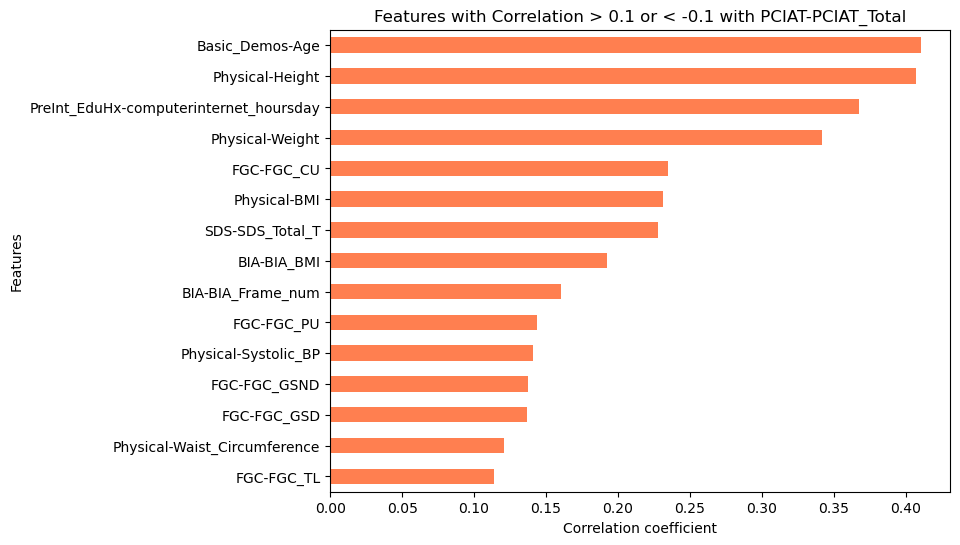

In [60]:
plt.figure(figsize=(8, 6))
filtered_corr.sort_values().plot(kind='barh', color='coral')
plt.title('Features with Correlation > 0.1 or < -0.1 with PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()

In [32]:
train_df = train_df.drop(columns=other_corr_columns)
test_df = test_df.drop(columns=other_corr_columns)

In [33]:
train_ts = load_time_series("child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


In [34]:
TARGET_COLS = [
    "PCIAT-Season",
    "PCIAT-PCIAT_01",
    "PCIAT-PCIAT_02",
    "PCIAT-PCIAT_03",
    "PCIAT-PCIAT_04",
    "PCIAT-PCIAT_05",
    "PCIAT-PCIAT_06",
    "PCIAT-PCIAT_07",
    "PCIAT-PCIAT_08",
    "PCIAT-PCIAT_09",
    "PCIAT-PCIAT_10",
    "PCIAT-PCIAT_11",
    "PCIAT-PCIAT_12",
    "PCIAT-PCIAT_13",
    "PCIAT-PCIAT_14",
    "PCIAT-PCIAT_15",
    "PCIAT-PCIAT_16",    
    "PCIAT-PCIAT_17",
    "PCIAT-PCIAT_18",
    "PCIAT-PCIAT_19",
    "PCIAT-PCIAT_20",
    "PCIAT-PCIAT_Total"
]
train_df = train_df.drop(TARGET_COLS,axis=1)

In [37]:
train_df = pd.merge(train_df, train_ts, how="left", on='id')
test_df = pd.merge(test_df, test_ts, how="left", on='id')

In [38]:
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

In [39]:
print(f'Train Shape : {train_df.shape} || Test Shape : {test_df.shape}')

Train Shape : (2719, 131) || Test Shape : (20, 130)


In [41]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [42]:
X_train = train_df.drop(columns=['sii'])
y_train = train_df['sii'] 
X_test = test_df

model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

test_df['sii'] = model.predict(X_test)

In [43]:
submit_df = pd.concat([test_id, test_df['sii']], axis=1)
submit_df['sii'] = submit_df['sii'].astype(int)

In [44]:
submit_df

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,0
3,00115b9f,1
4,0016bb22,0
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,0
9,0083e397,0


In [45]:
submit_df.to_csv('submission.csv', index=False)